# Model Training

## Imports

In [61]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

## Loading best result grid search

In [29]:
df = pd.read_csv("/kaggle/input/image-size-gridsearch-result/image_size_gridsearch_result.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.sort_values("test_accuracy", ascending=False)
df.head()

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


Class_weight is overgenomen uit notebook 4

In [30]:
best_result = df.iloc[0]
width = best_result["width"]
height = best_result["height"]
statistic = best_result["statistic"]
interpolation = best_result["interpolation"]
painters = ["Mondriaan", "Picasso"]
base_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
class_weight = {0: 2.8156565656565657, 1: 0.6079607415485279}

## Helper functions

In [31]:
def build_model(width, height, data_augmentation=None):
    model_layers = [
        layers.InputLayer(shape=(width, height, 3)),
    ]
    if data_augmentation:
        model_layers.append(data_augmentation)
    
    model_layers.extend([
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    model = keras.Sequential(model_layers)
    return model

model = build_model(width, height)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 603, 647, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 601, 645, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 300, 322, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 298, 320, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 149, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 147, 158, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 73, 79, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 71, 77, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 35, 38, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 33, 36, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 304128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │         304,129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,282,625 (4.89 MB)

 Trainable params: 1,282,625 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [33]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

train, val, test = load_dataset(base_dir, painters, width, height, interpolation=interpolation)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


In [48]:
def print_classifiction_report(model, test_dataset):
    y_pred = model.predict(test_dataset)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    print(classification_report(y_true, y_pred, zero_division=0))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        cmap='Blues'
    )
    plt.title('Confusion Matrix')
    plt.show()

## Model training

### Model listing 8.7

In [35]:
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7.keras",
save_best_only=True,
monitor="val_loss")
]


history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.4919 - loss: 1.2316 - val_accuracy: 0.2480 - val_loss: 0.7812
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.5623 - loss: 0.7490 - val_accuracy: 0.6253 - val_loss: 0.6839
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.6478 - loss: 0.6872 - val_accuracy: 0.5957 - val_loss: 0.6778
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.6777 - loss: 0.6330 - val_accuracy: 0.6792 - val_loss: 0.6035
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6959 - loss: 0.5459 - val_accuracy: 0.3154 - val_loss: 1.5943
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6892 - loss: 0.6475 - val_accuracy: 0.8706 - val_loss: 0.3465
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.7655 - loss: 0.7318 - val_accuracy: 0.6280 - val_loss: 0.6341
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.8015 - loss: 0.4656 - val_accuracy: 

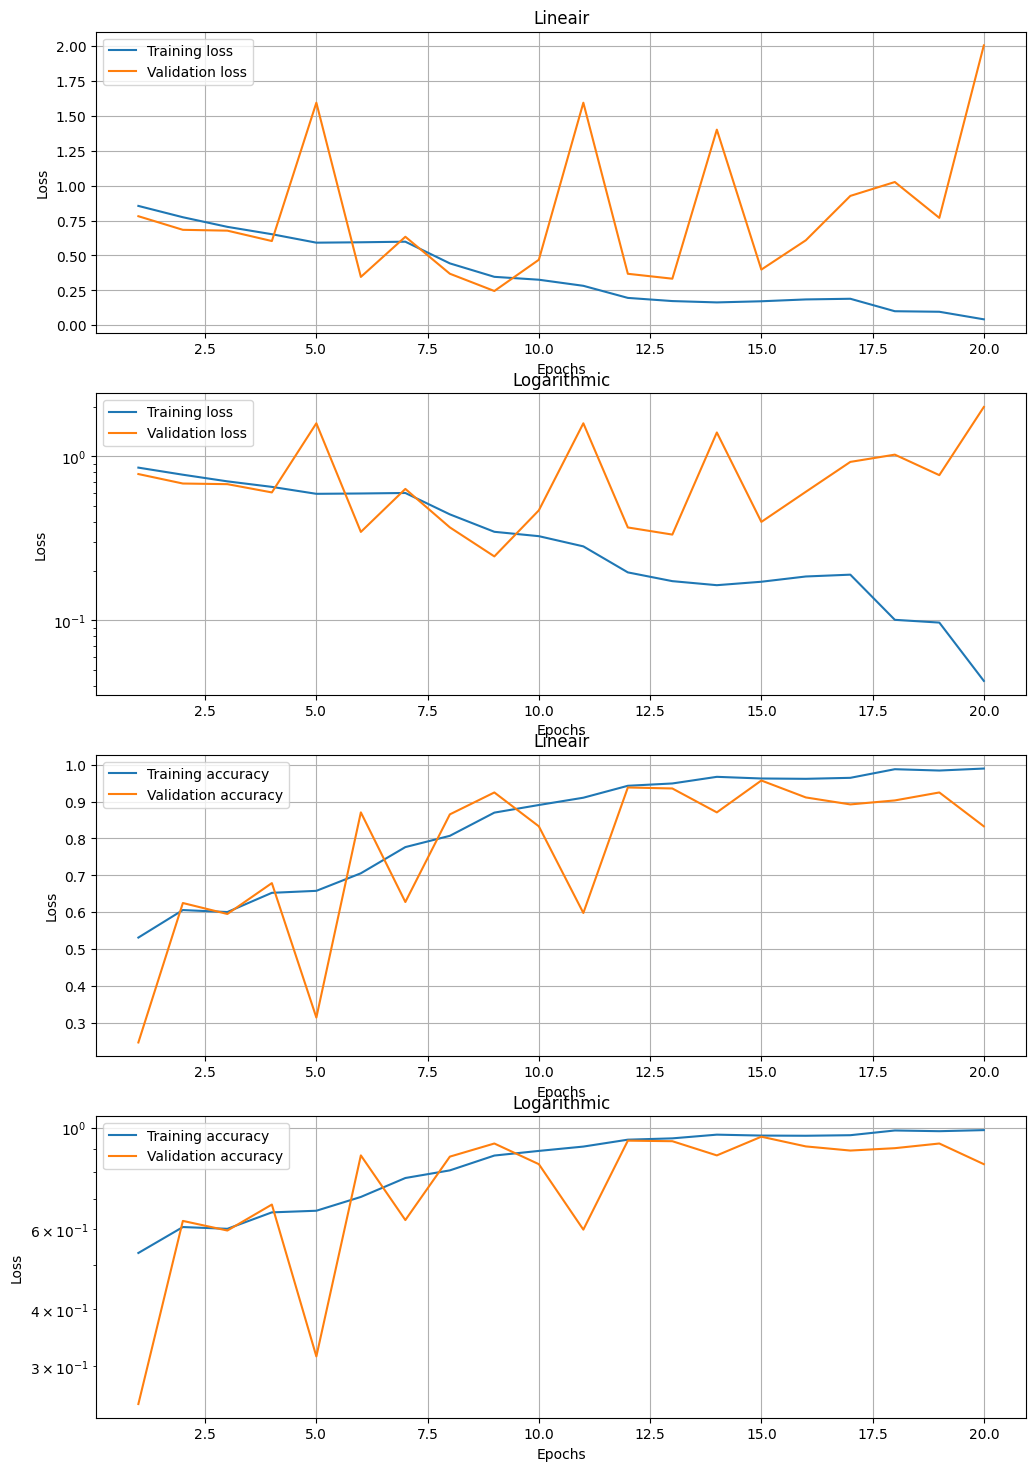

In [36]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
              precision    recall  f1-score   support

           0       0.14      0.23      0.18        66
           1       0.81      0.71      0.76       305

    accuracy                           0.62       371
   macro avg       0.48      0.47      0.47       371
weighted avg       0.69      0.62      0.65       371



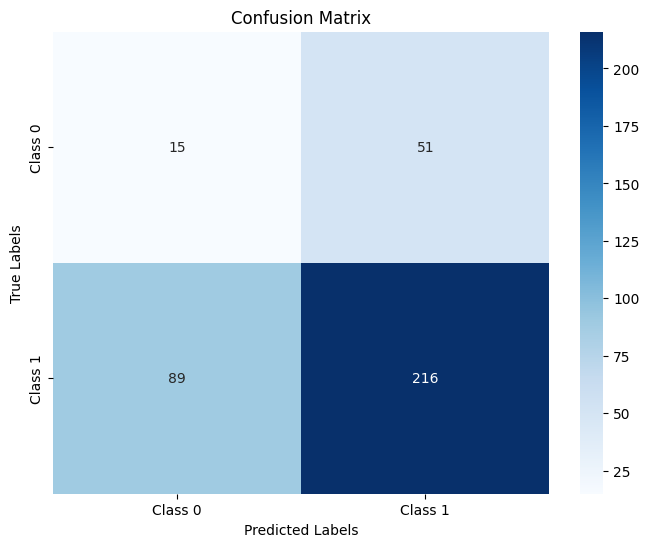

In [37]:
print_classifiction_report(model, test)

### Model listing 8.7 met data augmentation 8.14

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.7_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=20, validation_data=val, class_weight=class_weight, callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.5669 - loss: 1.3989 - val_accuracy: 0.1779 - val_loss: 0.6971
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6303 - loss: 0.7263 - val_accuracy: 0.8140 - val_loss: 0.4328
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5426 - loss: 0.7257 - val_accuracy: 0.8275 - val_loss: 0.4228
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6978 - loss: 0.6181 - val_accuracy: 0.5202 - val_loss: 0.7008
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6504 - loss: 0.5889 - val_accuracy: 0.5310 - val_loss: 0.6468
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6783 - loss: 0.5754 - val_accuracy: 0.4717 - val_loss: 1.0255
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7373 - loss: 0.6253 - val_accuracy: 0.7520 - val_loss: 0.6358
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.8190 - loss: 1.7558 - val_accuracy: 0

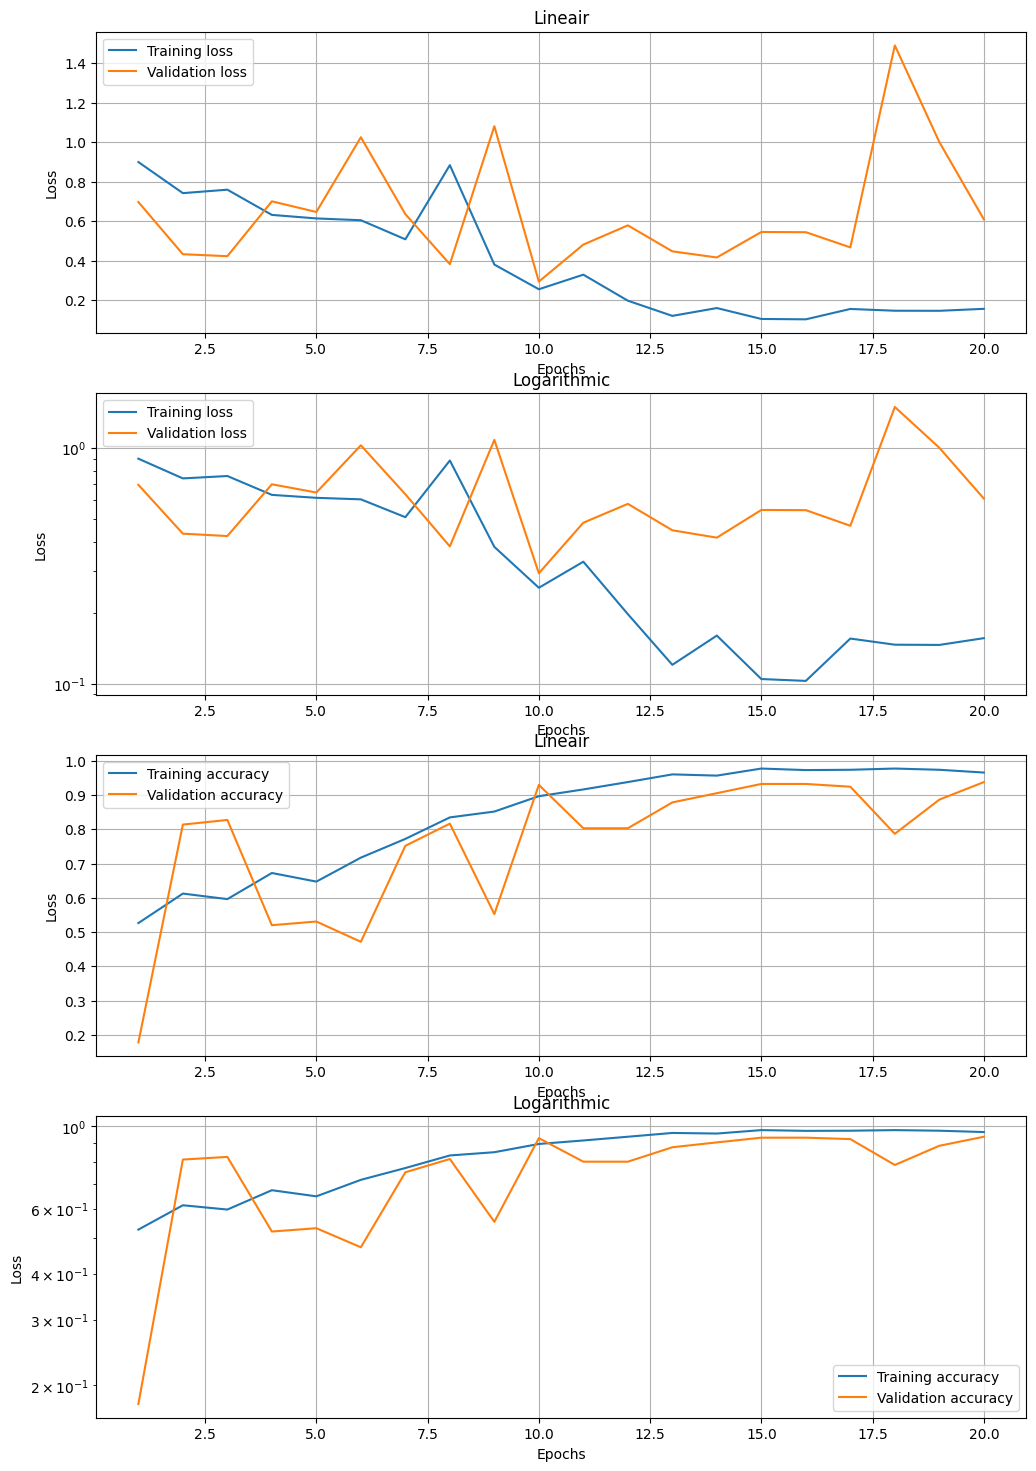

In [39]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
              precision    recall  f1-score   support

           0       0.24      0.24      0.24        66
           1       0.84      0.83      0.83       305

    accuracy                           0.73       371
   macro avg       0.54      0.54      0.54       371
weighted avg       0.73      0.73      0.73       371



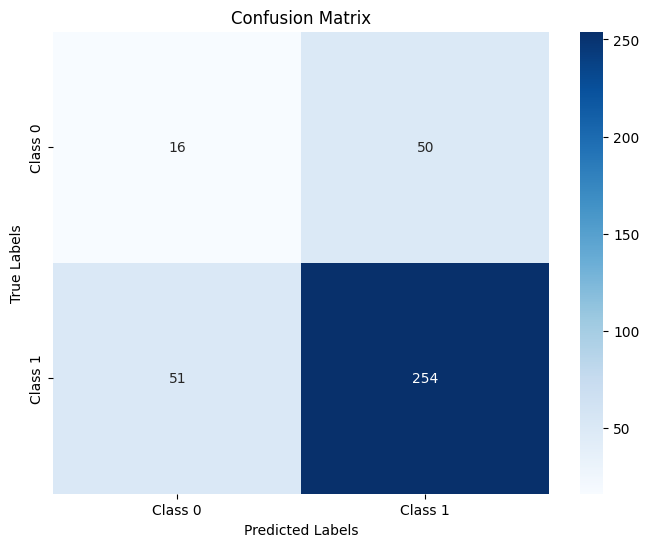

In [40]:
print_classifiction_report(model, test)

### Model listing 8.16

In [41]:
inputs = keras.Input(shape=(width, height, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="listing_8.16.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(train, epochs=50, validation_data=val, class_weight=class_weight)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.6086 - loss: 5.8017 - val_accuracy: 0.5526 - val_loss: 0.6929
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.5888 - loss: 0.7273 - val_accuracy: 0.7574 - val_loss: 0.6765
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6531 - loss: 0.6850 - val_accuracy: 0.4663 - val_loss: 0.6854
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.6038 - loss: 0.6739 - val_accuracy: 0.8005 - val_loss: 0.4158
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.6133 - loss: 0.7595 - val_accuracy: 0.8032 - val_loss: 0.4423
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6495 - loss: 0.6399 - val_accuracy: 0.3558 - val_loss: 0.9919
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6131 - loss: 0.5994 - val_accuracy: 0.4987 - val_loss: 0.7648
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.6211 - loss: 0.7250 - val_accu

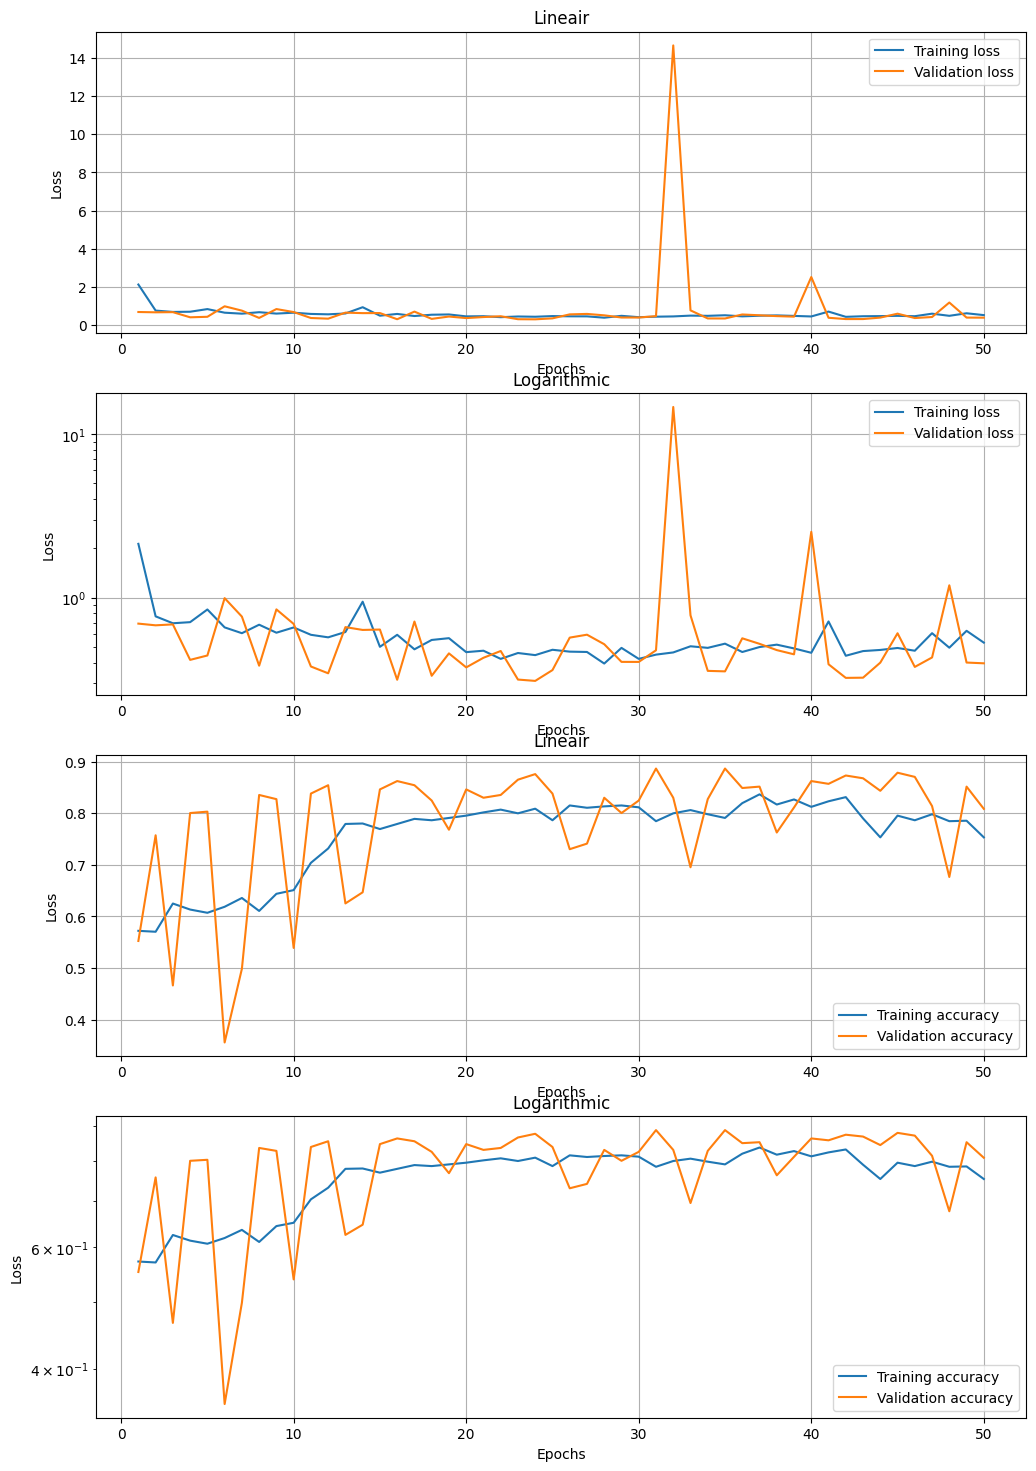

In [42]:
plot_loss(history)

In [49]:
print_classifiction_report(model, test)

ValueError: Input 0 of layer "functional_11" is incompatible with the layer: expected shape=(None, 5, 5, 512), found shape=(16, 603, 647, 3)

### Feature extraction met VGG16

In [63]:
def print_classification_report_and_confusion_matrix(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    y_pred = np.where(y_pred > 0.5, 1, 0)  
    y_true = test_labels

    print(classification_report(y_true, y_pred, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1']
    )
    plt.title('Confusion Matrix')
    plt.show()

In [44]:
conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 603, 647, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 603, 647, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 603, 647, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 301, 323, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 301, 323, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 301, 323, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 150, 161, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 150, 161, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 150, 161, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 150, 161, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 75, 80, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 75, 80, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 75, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 75, 80, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 37, 40, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 37, 40, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 18, 20, 512)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(val)
test_features, test_labels = get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [46]:
train_features.shape

(1115, 18, 20, 512)

In [50]:
input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_features, train_labels,
epochs=20,
validation_data=(val_features, val_labels),
callbacks=callbacks)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8056 - loss: 511.6193 - val_accuracy: 0.9164 - val_loss: 151.1251
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9707 - loss: 26.0721 - val_accuracy: 0.9434 - val_loss: 104.3806
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9670 - loss: 37.1323 - val_accuracy: 0.9542 - val_loss: 66.8845
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9773 - loss: 20.8564 - val_accuracy: 0.9757 - val_loss: 37.5811
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9975 - loss: 1.0425 - val_accuracy: 0.9677 - val_loss: 43.5607
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9899 - loss: 5.3808 - val_accuracy: 0.9623 - val_loss: 66.6460
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9967 - loss: 2.2333 - val_accuracy: 0.9623 - val_loss: 63.4133
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9944 - loss: 4.9589 - val_accur

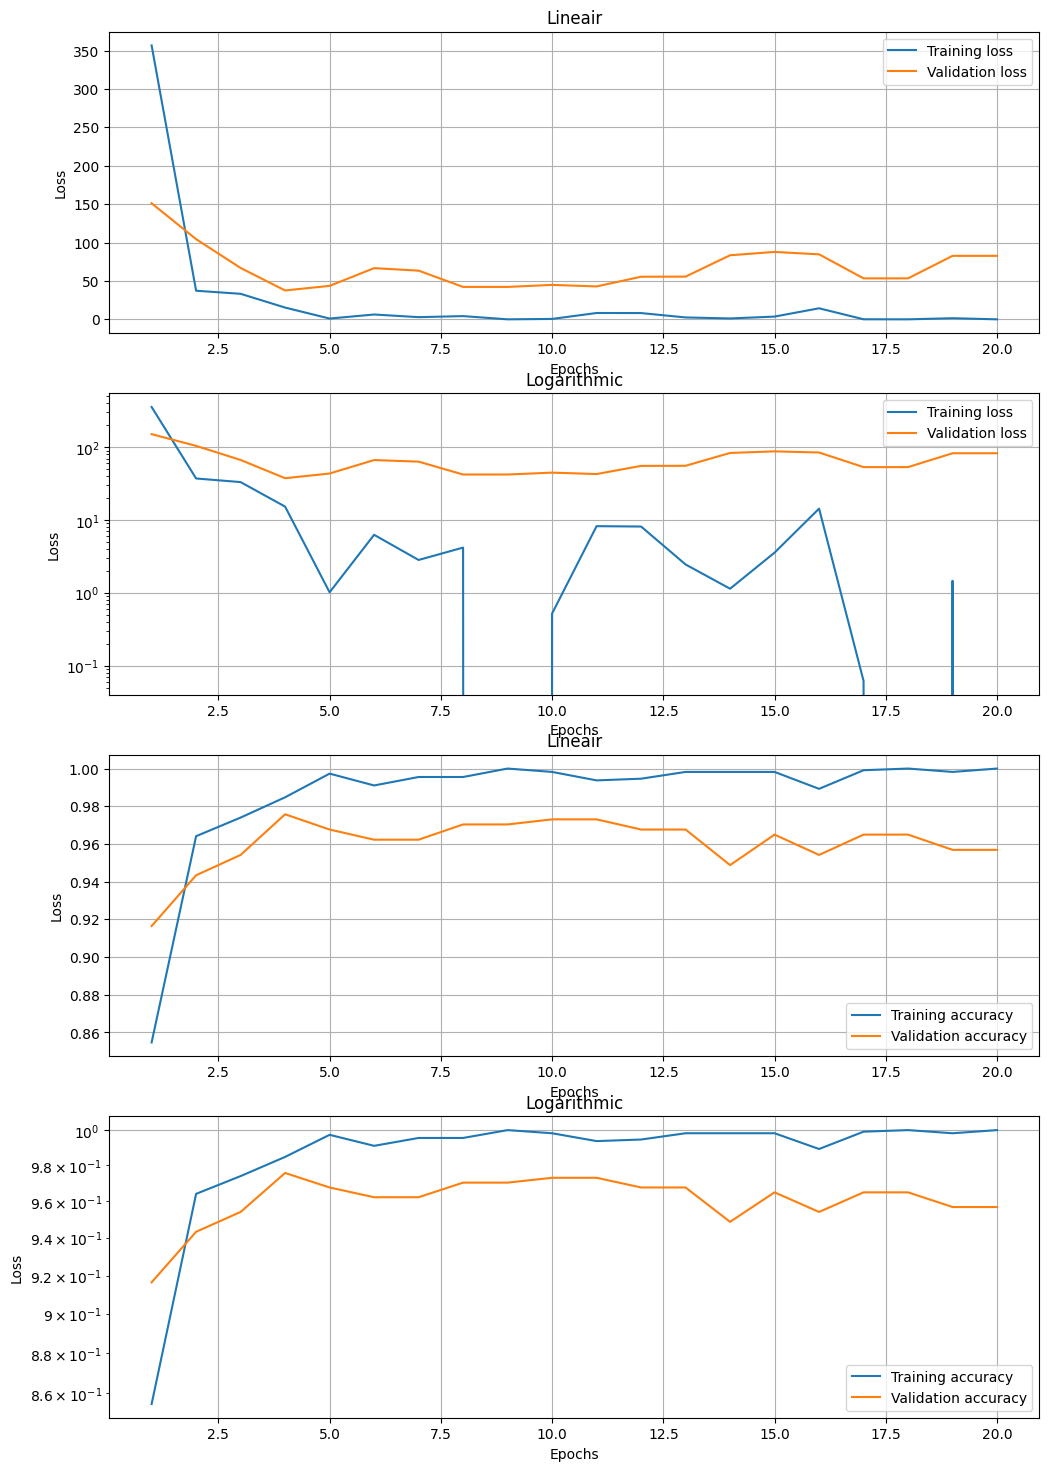

In [51]:
plot_loss(history)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0       0.98      0.74      0.84        66
           1       0.95      1.00      0.97       305

    accuracy                           0.95       371
   macro avg       0.96      0.87      0.91       371
weighted avg       0.95      0.95      0.95       371



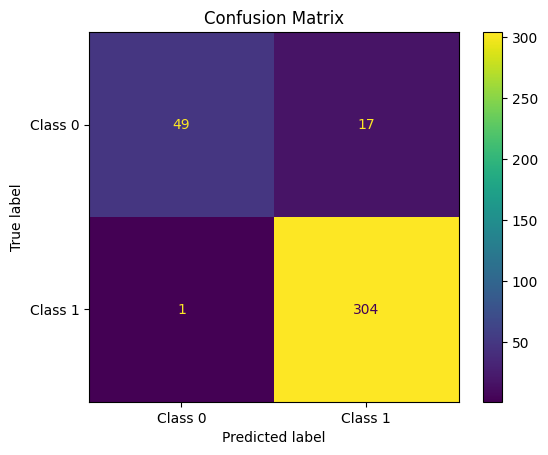

In [64]:
print_classification_report_and_confusion_matrix(model, test_features, test_labels)

### Uitbreiding met data augmentation

In [66]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
conv_base.trainable = False

In [67]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [78]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
    ]
history = model.fit(
train,
epochs=20,
validation_data=val,
callbacks=callbacks)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - accuracy: 0.8292 - loss: 196.6760 - val_accuracy: 0.9137 - val_loss: 73.4790
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 419ms/step - accuracy: 0.9325 - loss: 27.4598 - val_accuracy: 0.9245 - val_loss: 83.9356
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - accuracy: 0.9455 - loss: 28.5107 - val_accuracy: 0.9434 - val_loss: 43.4833
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.9635 - loss: 17.8022 - val_accuracy: 0.9434 - val_loss: 59.5758
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - accuracy: 0.9721 - loss: 11.1175 - val_accuracy: 0.9488 - val_loss: 38.5926
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - accuracy: 0.9721 - loss: 10.1997 - val_accuracy: 0.9434 - val_loss: 37.1299
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.9800 - loss: 10.0254 - val_accuracy: 0.9542 - val_loss: 42.0810
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.9750 - loss: 9.

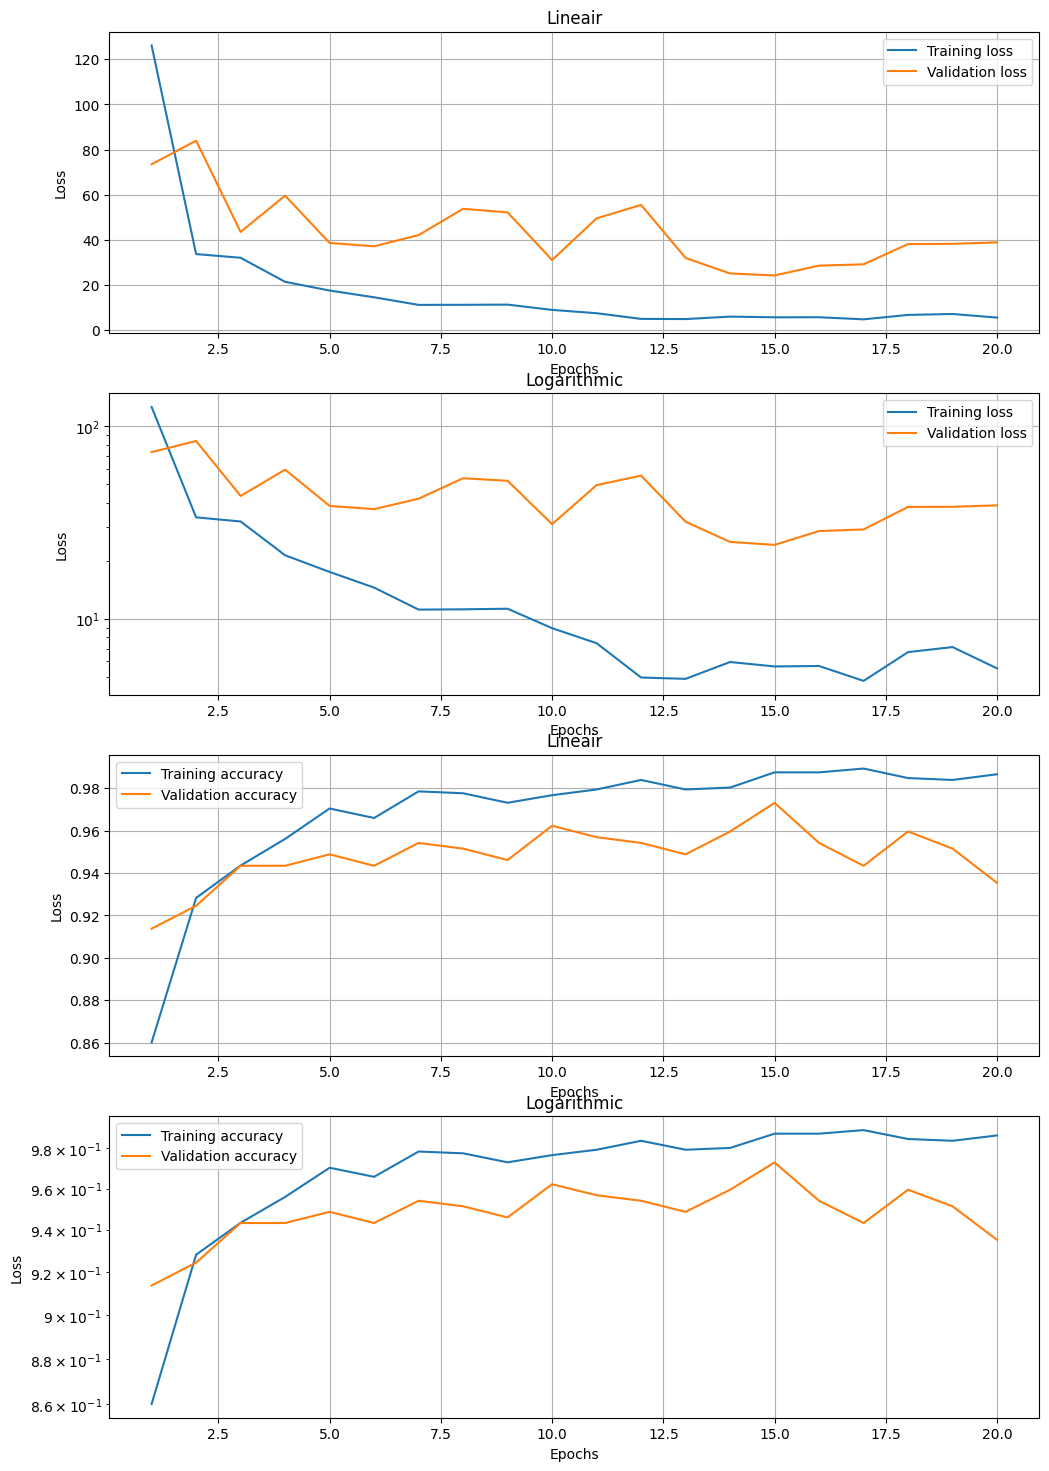

In [79]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step
              precision    recall  f1-score   support

           0       0.19      0.23      0.21        66
           1       0.82      0.79      0.81       305

    accuracy                           0.69       371
   macro avg       0.51      0.51      0.51       371
weighted avg       0.71      0.69      0.70       371



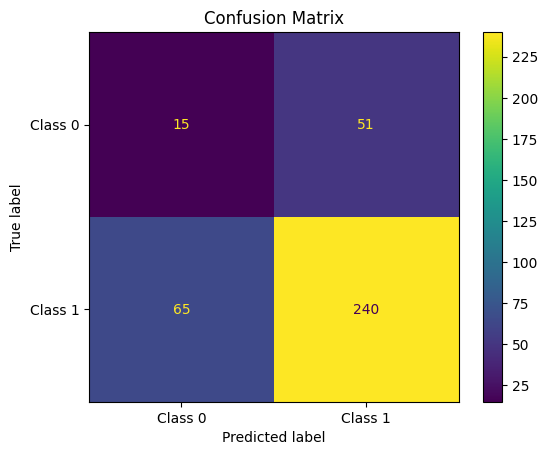

In [81]:
print_classification_report_and_confusion_matrix(model, test, test_labels)

### Finetuning van VGG16 conv base

In [82]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [84]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [86]:
model.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")]
history = model.fit(train,epochs=30,validation_data=val,callbacks=callbacks)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 482ms/step - accuracy: 0.9884 - loss: 5.2490 - val_accuracy: 0.9488 - val_loss: 54.5900
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 444ms/step - accuracy: 0.9841 - loss: 6.6311 - val_accuracy: 0.9515 - val_loss: 58.6032
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 486ms/step - accuracy: 0.9924 - loss: 3.9356 - val_accuracy: 0.9569 - val_loss: 32.2022
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - accuracy: 0.9969 - loss: 0.7252 - val_accuracy: 0.9488 - val_loss: 59.0446
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 488ms/step - accuracy: 0.9952 - loss: 1.6596 - val_accuracy: 0.9704 - val_loss: 23.0931
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 485ms/step - accuracy: 0.9929 - loss: 1.6090 - val_accuracy: 0.9596 - val_loss: 21.4984
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 485ms/step - accuracy: 0.9902 - loss: 0.8402 - val_accuracy: 0.9596 - val_loss: 19.7733
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.9923 - loss: 1.2220 - v

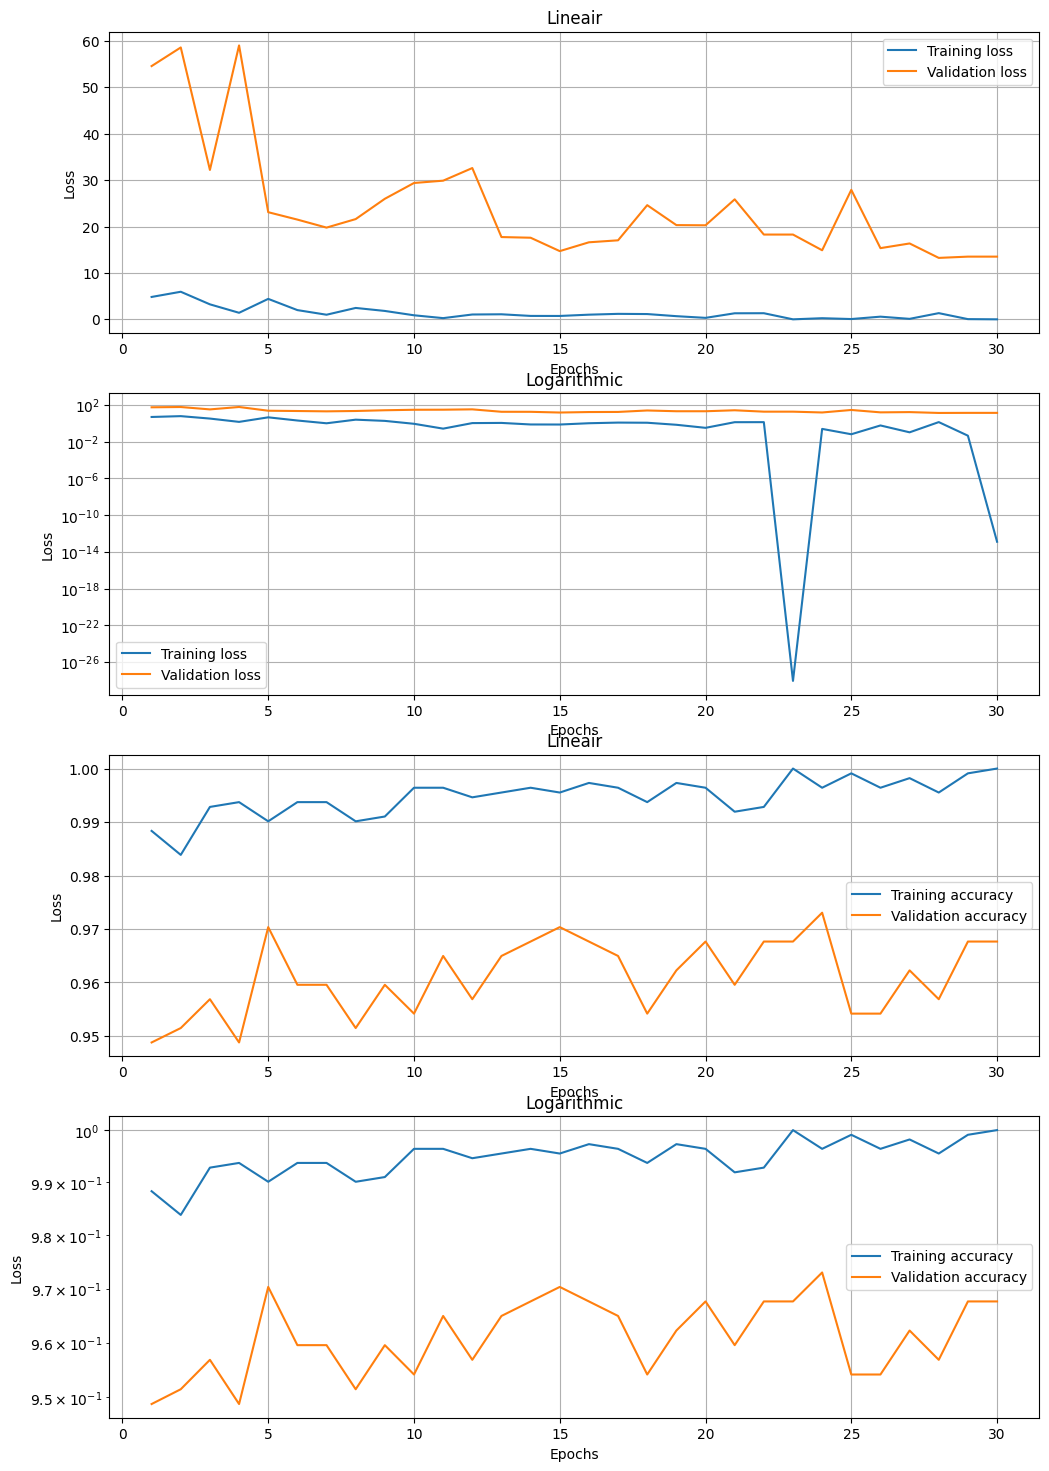

In [87]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step
              precision    recall  f1-score   support

           0       0.18      0.18      0.18        66
           1       0.82      0.82      0.82       305

    accuracy                           0.70       371
   macro avg       0.50      0.50      0.50       371
weighted avg       0.71      0.70      0.71       371



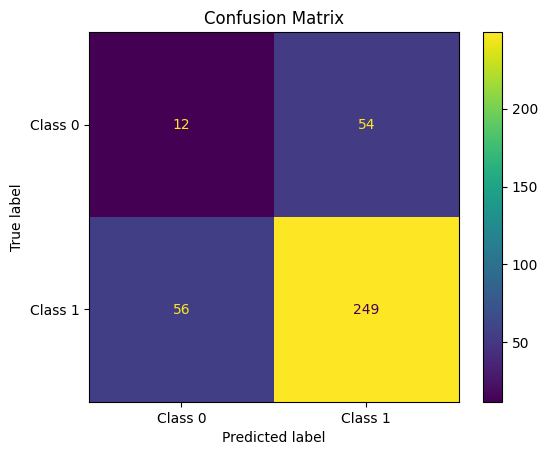

In [88]:
print_classification_report_and_confusion_matrix(model, test, test_labels)